In [1]:
code_path = 'Semantic-Aware-Attention-Based-Deep-Object-Co-segmentation/'

In [2]:
import torch, math, time
import numpy as np
import cv2
import PIL
from matplotlib import pyplot as plt
from matplotlib import image
%matplotlib inline
import skimage, skimage.transform
import sys
sys.path.append(code_path)
from torchvision import models
import scipy.io as sio
from scipy.io import loadmat
import torch.nn.functional as F
# CUDA flag. Speed-up due to CUDA is mostly noticable for large batches.
cuda = True
from PIL import Image,ImageDraw
from torchvision.utils import save_image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, Scale, ToPILImage
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
#from skimage import io, transform
from model import *
import segmentation_models_pytorch as smp
import albumentations as albu
from tqdm.auto import tqdm
import torch.nn as nn
import torchvision.models.resnet as resnet_util
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from torch.optim import Adam
import os
from copy import deepcopy
import random
from random import shuffle

## HAM DATA

In [3]:
# change load dir
img_path1 = 'Data_ham/HAM10000_images_part_1/' 
img_path2 = 'Data_ham/HAM10000_images_part_2/'
gt_path = 'Data_ham/HAM_MASK/'

im_dir = np.array(sorted(os.listdir(img_path1)+os.listdir(img_path2)))
gt_dir = np.array(sorted(os.listdir(gt_path)))

In [ ]:
# change save path
el_path = 'Data_ham/HAM_ellipse/'
grab_path = 'Data_ham/HAM_grabcut/'
os.mkdir(el_path)
os.mkdir(grab_path)

### Generate Ellipse

In [4]:
def draw_ellipse(gray):
    thresh = cv2.threshold(gray, 252, 255, cv2.THRESH_BINARY)[1]
    points = np.column_stack(np.where(thresh.transpose() > 0))
    hull = cv2.convexHull(points)
    if hull.shape[0]<5:
        return None,None,None,None,None
    ((centx,centy), (width,height), angle) = cv2.fitEllipse(hull)
    result = gray.copy()
    cv2.ellipse(result, (int(centx),int(centy)), (int(width/2),int(height/2)), angle, 0, 360, (0,0,255), 2)
    return centx,centy,width,height,angle

In [5]:
from matplotlib.patches import Ellipse
def save_mask(i):
    img = image.imread(gt_path+gt_dir[i])
    if (img==1).all() or (img==0).all():
        wrong.append(i)
        return
    if len(img.shape)==3:
        img = img[:,:,0]
    sizes = np.shape(img) 
    fake=np.zeros(sizes,np.uint8)
    fig = plt.figure()
    fig.set_size_inches(1, 1, forward=False)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    centx,centy,width,height,angle = draw_ellipse(255*img.astype('uint8'))
    if centx==None:
        wrong.append(i)
        return
    ax.add_patch(Ellipse((centx,centy), height=height, 
                    width=width,
                    angle=angle,
                    edgecolor='white',
                    facecolor='white',
                    linewidth=0))

    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(fake, cmap = 'gray')
    plt.savefig(el_path+gt_dir[i], dpi = sizes[1],bbox_inches = 'tight',pad_inches = 0) 
    plt.close()

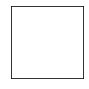

In [88]:
wrong=[]
for i in range(len(gt_dir)):
    save_mask(i)

In [89]:
wrong

[1736, 3925, 5513]

### Generate Grabcut

In [ ]:
el_dir = np.array(sorted(os.listdir(el_path)))

In [ ]:
def getRect(mask):
    cand=np.where(mask==1)
    x_min=min(cand[1])
    x_max=max(cand[1])
    y_min=min(cand[0])
    y_max=max(cand[0])
    w = x_max-x_min
    h = y_max-y_min
    return (x_min,y_min,w,h)

def getGrabcut(img,mask):
    img = img.astype('uint8')
    mask = mask.astype('uint8')
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    img1 = img*mask[:,:,np.newaxis]
    mask1 = deepcopy(mask)
    rect = getRect(mask1)
    cv2.grabCut(img1,mask1,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask1==2)|(mask1==0),0,1).astype('uint8')
    if (mask2==0).all():
        return mask
    return mask2

In [ ]:
wrong=[1736, 3925, 5513]
im_dir=np.delete(im_dir,wrong)
gt_dir=np.delete(gt_dir,wrong)

In [ ]:
for i in range(len(im_dir)):
    if os.path.isfile(os.path.join(img_path1, im_dir[i])):
        img=image.imread(img_path1+im_dir[i])
    else:
        img = image.imread(img_path2+im_dir[i])
    mas = image.imread(el_path+el_dir[i])
    newmask = getGrabcut(cv2.resize(img,(120,120)),cv2.resize(mas[:,:,0],(120,120)))
    cv2.imwrite(grab_path+el_dir[i], newmask)

In [ ]:
grab_dir = np.array(sorted(os.listdir(grab_path)))

In [ ]:
for i in range(len(grab_dir)):
    cv2.imwrite(grab_path+grab_dir[i],(255*255*image.imread(grab_path+grab_dir[i])).astype('uint8'))

### Genarate Cluster Label

In [ ]:
# to change
num_class=45
label_save_path='Data_ham/HAM_LABELS.npy'
recist_save_path='Data_ham/HAM_RECIST.npy'

In [90]:
recist = []
for i in range(len(gt_dir)):
    if i in wrong:
        continue
    img = image.imread(gt_path+gt_dir[i])
    if len(img.shape)==3:
        img=img[:,:,0]
    img = cv2.resize(img,(120,120))
    recist.append(draw_ellipse(255*img.astype('uint8')))

In [91]:
recist=np.stack(recist)
recist.shape

(10012, 5)

In [ ]:
np.save(recist_save_path,recist)

In [92]:
from sklearn.cluster import KMeans
recist = np.load(recist_save_path)
kmeans = KMeans(n_clusters=num_class, random_state=0).fit(recist)
labels = kmeans.labels_

In [94]:
labels.shape

(10012,)

In [95]:
np.save(label_save_path,labels)